In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import altair as alt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import  TensorBoard
from time import  time
from tabulate import tabulate
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

In [5]:
import tensorflow_similarity as tfsim
from tensorflow_similarity.utils import tf_cap_memory
from tensorflow_similarity.losses import TripletLoss
from tensorflow_similarity.layers import MetricEmbedding
from tensorflow_similarity.model import SimilarityModel
from tensorflow_similarity.distance_metrics import avg_neg, avg_pos, dist_gap, max_pos, min_neg
from tensorflow_similarity.samplers import MultiShotMemorySampler
from tensorflow_similarity.samplers import select_examples
from tensorflow_similarity.visualization import viz_neigbors_imgs
from tensorflow_similarity.visualization import confusion_matrix

In [6]:
# make sure TF don't blew up
tf_cap_memory()
print('TensorFlow:', tf.__version__)
print('TensorFlow Similarity', tfsim.__version__)

TensorFlow: 2.4.0
TensorFlow Similarity 0.17.11


In [7]:
BATCH_SIZE = 64 #@param {type:"integer"}
CLASS_PER_BATCH = 8 #@param {type:"integer"}
BATCH_PER_EPOCH = 3000 #@param {type:"integer"}
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = tf.constant(x_train / 255.0, dtype='float32')
x_test = tf.constant(x_test / 255.0, dtype='float32')
sampler = MultiShotMemorySampler(x_train, y_train, class_per_batch=CLASS_PER_BATCH, batch_size=BATCH_SIZE, batch_per_epoch=BATCH_PER_EPOCH)

indexing classes: 100%|██████████| 60000/60000 [00:00<00:00, 2181938.49it/s]


In [8]:
# experimentla display functions
from PIL import Image
from IPython.core.display import HTML
import io
import base64
def make_base64_img(v, height=128):
    img =  Image.fromarray(np.uint8(v*255))
    img = img.convert('RGB')
    img_bytes = io.BytesIO()
    img.save(img_bytes, format="PNG")
    # img_content = img_bytes.getvalue()

    i = '><img height="%s" src="data:image/png;base64,%s"/>' % (height, str(base64.b64encode(img_bytes.getvalue()))[2:-1])
    return i

def inspect(vid):
    fig, ax = plt.subplots()
    im = ax.imshow(x_test[vid], interpolation='bilinear', cmap='viridis')
    ax.set_title(txt_labels[y_test[vid]])
    ax.axis('off')  # clear x-axis and y-axis
    fig.show()

In [9]:
data_augmentation = tf.keras.Sequential([
  # layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.2)
  ])

In [10]:
def get_model():
    tf.keras.backend.clear_session()
    inputs = tf.keras.layers.Input(shape=(28,28))
    x = layers.Reshape((28, 28, 1))(inputs)
    x = data_augmentation(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(512, 11, activation='relu')(x)

    x = layers.GlobalMaxPool2D()(x)
    x = layers.Flatten()(x)

    x = layers.BatchNormalization()(x)
    x = layers.Dense(64, activation='relu')(x)

    # dont make the embedding to large - its slow down the lookups
    e = layers.Dense(32)(x)

    # vs = layers.Dense(2, activation='softplus', name='visual_side')(x)
    vt = layers.Dense(2, activation=None, name='visual_top')(x)
    return SimilarityModel(inputs, [e, vt]) #, vs])
model = get_model()
model.summary()

Model: "similarity_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 28, 28, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 28, 28, 1)    0           reshape[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 28, 28, 1)    4           sequential[0][0]                 
___________________________________________________________________________________

In [11]:
import tensorflow_addons as tfa
distance = 'cosine' #@param ["cosine"]{allow-input: false}
positive_mining_strategy = 'hard' #@param ["easy", "hard"]{allow-input: false}
negative_mining_strategy = 'semi-hard'  #@param ["easy", "semi-hard", "hard"]{allow-input: false}
triplet_loss = TripletLoss(distance=distance,
    positive_mining_strategy='hard',
    negative_mining_strategy='hard')

visual_triplet_loss = tfa.losses.TripletSemiHardLoss(distance_metric='L2')

In [21]:
EPOCHS = 5 #@param {type:"integer"}
LR = 0.001  #@param {type:"float"}
model = get_model()
metrics = [dist_gap(distance), min_neg(distance), max_pos(distance)]
metrics = []
model.compile(optimizer=Adam(LR), metrics=metrics, loss=[triplet_loss, visual_triplet_loss])
history = model.fit(sampler, validation_data=(x_test, y_test), batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/5
3000/3000 [==============================] - 45s 15ms/step - loss: 1.2556 - dense_1_loss: 1.0243 - visual_top_loss: 0.2314 - val_loss: 1.1032 - val_dense_1_loss: 0.9982 - val_visual_top_loss: 0.1051
Epoch 2/5
3000/3000 [==============================] - 44s 15ms/step - loss: 0.9852 - dense_1_loss: 0.8941 - visual_top_loss: 0.0912 - val_loss: 0.9029 - val_dense_1_loss: 0.8269 - val_visual_top_loss: 0.0760
Epoch 3/5
3000/3000 [==============================] - 43s 14ms/step - loss: 0.8265 - dense_1_loss: 0.7611 - visual_top_loss: 0.0654 - val_loss: 0.8565 - val_dense_1_loss: 0.7945 - val_visual_top_loss: 0.0620
Epoch 4/5
3000/3000 [==============================] - 40s 13ms/step - loss: 0.7793 - dense_1_loss: 0.7277 - visual_top_loss: 0.0516 - val_loss: 0.8371 - val_dense_1_loss: 0.7760 - val_visual_top_loss: 0.0612
Epoch 5/5
3000/3000 [==============================] - 39s 13ms/step - loss: 0.7450 - dense_1_loss: 0.7013 - visual_top_loss: 0.0437 - val_loss: 0.8258 - val_dense_

In [22]:
# generate embeddings
NUM_EXAMPLES = 5000
txt_labels = ["T-shirt",  "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot", "Unknown"]
colors = ["#5E35B1",  "#6D4C41", "#D81B60", "#e53935", "#C0CA33", "#FFB300", "#039BE5", "#FB8C00", "#43A047", "#F4511E", "#757575"
]
embeddings, vizualized = model.predict(x_test[:NUM_EXAMPLES])
df  = pd.DataFrame.from_dict({
    "id": [i for i in range(NUM_EXAMPLES)],
    "x": [i[0] for i in vizualized],
    "y": [i[1] for i in vizualized],
    "label": [int(i) for i in y_test[:NUM_EXAMPLES]],
    "txt_label": [txt_labels[i] for i in y_test[:NUM_EXAMPLES]],
    "color": [colors[i] for i in y_test[:NUM_EXAMPLES]],
     # "base64": [make_base64_img(v) for v in x_test[:NUM_EXAMPLES]]
})
df.head()

,id,x,y,label,txt_label,color
0,0,6.709926,142.517761,9,Ankle Boot,#F4511E
1,1,-33.993809,-71.954300,2,Pullover,#D81B60
2,2,16.456972,-102.319519,1,Trouser,#6D4C41
3,3,-4.433551,-101.285843,1,Trouser,#6D4C41
4,4,-1.552105,-4.524775,6,Shirt,#039BE5


In [24]:
# define what user selection means
selection = alt.selection_multi(fields=['txt_label'])

# define color scale
color_scale = alt.Color('txt_label:N', legend=None,
                scale=alt.Scale(domain=txt_labels, range=colors))
alt_color =  alt.value('lightgray')
# conditional color -> if in selection color else lightgray
color = alt.condition(selection, color_scale, alt_color)

scatter = alt.Chart(df).mark_circle().encode(
    x='x:Q',
    y='y:Q',
    color=color,
    tooltip=['txt_label', 'id']
).interactive()

legend = alt.Chart(df).mark_rect().encode(
    y=alt.Y('txt_label', axis=alt.Axis(orient='right')),
    color=color
).add_selection(
    selection
)

# scatter | legend
scatter | legend

alt.HConcatChart(...)

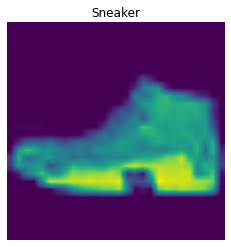

In [35]:
inspect(4693)

In [ ]:
https://github.com/vega/vega-tooltip/blob/master/docs/creating_your_tooltip.md

https://github.com/vega/vega-tooltip


https://altair-viz.github.io/user_guide/custom_renderers.html
https://github.com/altair-viz/altair/blob/d862ad494ecc0a5cff7e8b114df14e0796efa108/altair/utils/display.py#L166


In [12]:
# done on mnist digits
# removing activation and trusting the loss
# > magic gives nice clusters!
# Epoch 3/3
# 3000/3000 [==============================] - 37s 12ms/step - loss: 0.0854 - dense_1_loss: 0.0696 - visual_top_loss: 0.0158 - val_loss: 0.1866 - val_dense_1_loss: 0.1698 - val_visual_top_loss: 0.0168

# moving to side way better

# softsign on top look good
# 3000/3000 [==============================] - 39s 13ms/step - loss: 0.1857 - metric_embedding_loss: 0.1443 - visual_top_loss: 0.0414 - val_loss: 0.2907 - val_metric_embedding_loss: 0.2377 - val_visual_top_loss: 0.0530

# softplus on top and relu instread of SELU
# weird corner and loss abopu 0.5


# softsign on top and relu instread of SELU
# weird corner and loss abopu 0.5

# putting on top of l2   with l2 activation not better > creates a circle

#l2 instead of than is better but still struggle after 2 epoc
# loss = 0.7

# tahn push clusters on the corners
# loss 0.5 after 3 epooch

# BATCH 64 - 8 class > better 


#LR 0.0001 and 3 epochs  < bad
# Epoch 3/3
# 3000/3000 [==============================] - 37s 12ms/step - loss: 0.4010 - metric_embedding_loss: 0.3385 - visual_top_loss: 0.0626 - val_loss: 0.4906 - val_metric_embedding_loss: 0.4148 - val_visual_top_loss: 0.0758

# light data aug
# Epoch 2/2
# 3000/3000 [==============================] - 37s 12ms/step - loss: 0.2749 - metric_embedding_loss: 0.2402 - visual_top_loss: 0.0347 - val_loss: 0.2803 - val_metric_embedding_loss: 0.2466 - val_visual_top_loss: 0.0338


# extra dense not working (forgot copypast)

# Epoch 2/2
# 3000/3000 [==============================] - 38s 13ms/step - loss: 0.2800 - metric_embedding_loss: 0.2464 - visual_top_loss: 0.0336 - val_loss: 0.2730 - val_metric_embedding_loss: 0.2510 - val_visual_top_loss: 0.0219


# Single epoch optimization

# batch norm before conv > better
#3000/3000 [==============================] - 39s 13ms/step - loss: 0.8589 - metric_embedding_loss: 0.7002 - visual_top_loss: 0.1587 - val_loss: 0.4307 - val_metric_embedding_loss: 0.3934 - val_visual_top_loss: 0.0373

# Extra dense and batch norm > nope
# 3000/3000 [==============================] - 41s 13ms/step - loss: 0.9501 - metric_embedding_loss: 0.7522 - visual_top_loss: 0.1979 - val_loss: 0.5545 - val_metric_embedding_loss: 0.5118 - val_visual_top_loss: 0.0427

# DENSE 64 > 128 > nope
#3000/3000 [==============================] - 36s 12ms/step - loss: 0.8404 - metric_embedding_loss: 0.6961 - visual_top_loss: 0.1443 - val_loss: 0.4172 - val_metric_embedding_loss: 0.3948 - val_visual_top_loss: 0.0224

# SELU on the conv (no activation before) < better
#3000/3000 [==============================] - 36s 12ms/step - loss: 0.8387 - metric_embedding_loss: 0.6784 - visual_top_loss: 0.1602 - val_loss: 0.3479 - val_metric_embedding_loss: 0.3174 - val_visual_top_loss: 0.0305

# kernelsize 11 < better
#3000/3000 [==============================] - 36s 12ms/step - loss: 0.8449 - metric_embedding_loss: 0.6991 - visual_top_loss: 0.1457 - val_loss: 0.4002 - val_metric_embedding_loss: 0.3687 - val_visual_top_loss: 0.0314

# RELU instead of SELU > nope
#3000/3000 [==============================] - 36s 12ms/step - loss: 0.9284 - metric_embedding_loss: 0.7518 - visual_top_loss: 0.1765 - val_loss: 0.3937 - val_metric_embedding_loss: 0.3587 - val_visual_top_loss: 0.0350

# 2 Conv512 > bad
# 3000/3000 [==============================] - 116s 38ms/step - loss: 0.9625 - metric_embedding_loss: 0.7860 - visual_top_loss: 0.1765 - val_loss: 0.4329 - val_metric_embedding_loss: 0.3950 - val_visual_top_loss: 0.0379


#3000/3000 [==============================] - 37s 12ms/step - loss: 0.9612 - metric_embedding_loss: 0.7691 - visual_top_loss: 0.1920 - val_loss: 0.5485 - val_metric_embedding_loss: 0.4270 - val_visual_top_loss: 0.1216 


#256 layers
# 3000/3000 [==============================] - 36s 12ms/step - loss: 1.0759 - metric_embedding_loss: 0.8544 - visual_top_loss: 0.2215 - val_loss: 0.5257 - val_metric_embedding_loss: 0.4641 - val_visual_top_loss: 0.0616